# Aggregated Latencies Breakdown

In [17]:
import pandas as pd
import numpy as np
from pathlib import Path


def load_df(path: str) -> pd.DataFrame:
    """
    Load CSV that looks like:

        timestamp,gpu_id,attn_ms,mlp_ms
        185.8592381477356,0,0.3739,0.7862

    If your file has more columns, we only keep:
        timestamp (0), gpu_id (1), attn_ms (2), mlp_ms (3).
    """
    df = pd.read_csv(
        path,
        header=None,          # treat header row as data, then skip it
        skiprows=1,           # skip the proper header
        usecols=[0, 1, 2, 3], # timestamp, gpu_id, attn_ms, mlp_ms
        names=["timestamp", "gpu_id", "attn_ms", "mlp_ms"],
        engine="python",      # robust to weird CSVs
    )

    # Ensure numeric types
    df["timestamp"] = df["timestamp"].astype(float)
    df["gpu_id"] = df["gpu_id"].astype(int)
    df["attn_ms"] = df["attn_ms"].astype(float)
    df["mlp_ms"] = df["mlp_ms"].astype(float)
    df["total_ms"] = df["attn_ms"] + df["mlp_ms"]

    return df


def summarize_by_gpu(df: pd.DataFrame) -> pd.DataFrame:
    """Compute per-GPU latency stats and return as a DataFrame."""
    rows = []
    for gpu, sub in df.groupby("gpu_id"):
        rows.append(
            {
                "gpu_id": gpu,
                #"count": len(sub),
                "attn_mean": sub["attn_ms"].mean(),
                "attn_p50": sub["attn_ms"].quantile(0.5),
                "attn_p90": sub["attn_ms"].quantile(0.9),
                #"attn_p95": sub["attn_ms"].quantile(0.95),
                #"attn_p99": sub["attn_ms"].quantile(0.99),
                "mlp_mean": sub["mlp_ms"].mean(),
                "mlp_p50": sub["mlp_ms"].quantile(0.5),
                "mlp_p90": sub["mlp_ms"].quantile(0.9),
                #"mlp_p95": sub["mlp_ms"].quantile(0.95),
                #"mlp_p99": sub["mlp_ms"].quantile(0.99),
                "total_mean": sub["total_ms"].mean(),
                "total_p50": sub["total_ms"].quantile(0.5),
                "total_p90": sub["total_ms"].quantile(0.9),
                #"total_p95": sub["total_ms"].quantile(0.95),
                #"total_p99": sub["total_ms"].quantile(0.99),
            }
        )
    out = pd.DataFrame(rows)
    out = out.sort_values("gpu_id").reset_index(drop=True)
    return out


def summarize_over_time(df: pd.DataFrame, bucket_seconds: float = 1.0) -> pd.DataFrame:
    """
    Aggregate by time buckets (e.g. 1-second windows) and GPU.

    Returns a table with:
        sec         : integer bucket index (seconds since start / bucket size)
        gpu_id
        calls       : number of rows in that bucket
        attn_mean   : mean attn_ms in that bucket
        mlp_mean    : mean mlp_ms in that bucket
        total_mean  : mean total_ms in that bucket
    """
    if df.empty:
        return pd.DataFrame(
            columns=["sec", "gpu_id", "calls","total_mean", "attn_mean", "mlp_mean"]
        )

    t0 = df["timestamp"].min()
    tmp = df.copy()
    tmp["t_rel"] = tmp["timestamp"] - t0
    tmp["sec"] = (tmp["t_rel"] // bucket_seconds).astype(int)

    grouped = tmp.groupby(["sec", "gpu_id"])
    out = grouped.agg(
        calls=("attn_ms", "count"),
        attn_mean=("attn_ms", "mean"),
        mlp_mean=("mlp_ms", "mean"),
        total_mean=("total_ms", "mean"),
    ).reset_index()

    out = out.sort_values(["sec", "gpu_id"]).reset_index(drop=True)
    return out


def aggregate_latencies(csv_path: str,
                        bucket_seconds: float = 1.0,
                        out_prefix: str | None = None):
    """
    Convenience function for notebooks.

    Returns:
        df            : raw per-call data
        gpu_summary   : per-GPU aggregated stats
        time_summary  : per-time-bucket aggregated stats

    If out_prefix is given, also writes:
        <out_prefix>_gpu_summary.csv
        <out_prefix>_time_summary.csv
    """
    path = Path(csv_path)
    if not path.exists():
        raise FileNotFoundError(f"CSV file not found: {path}")

    df = load_df(str(path))
    gpu_summary = summarize_by_gpu(df)
    time_summary = summarize_over_time(df, bucket_seconds=bucket_seconds)

    if out_prefix:
        base = Path(out_prefix).with_suffix("")  # strip suffix if any
        gpu_csv = f"{base}_gpu_summary.csv"
        time_csv = f"{base}_time_summary.csv"
        gpu_summary.to_csv(gpu_csv, index=False)
        time_summary.to_csv(time_csv, index=False)

    return df, gpu_summary, time_summary


if __name__ == "__main__":
    TIMING_DIR = "./log/timing"
    csv_path = f"{TIMING_DIR}/gpt-oss-120b_tp1_dp4_ep1_off0_con256_IN32768_OUT1024.csv"

    df, gpu_summary, time_summary = aggregate_latencies(
        csv_path,
        bucket_seconds=1.0,   # change if you want different time buckets
        out_prefix=None       # or e.g. "stats" to write CSVs
    )

    display(gpu_summary)
    display(time_summary.head())


,gpu_id,attn_mean,attn_p50,attn_p90,mlp_mean,mlp_p50,mlp_p90,total_mean,total_p50,total_p90
0,0,4.276760,1.2894,4.49523,21.913675,1.2150,109.05730,26.190435,4.5959,114.31923
1,1,2.498654,0.7527,2.34633,23.716909,2.4260,112.54590,26.215563,4.5954,114.34823
2,2,2.507038,0.7738,2.35220,23.689073,2.4051,112.42756,26.196111,4.5774,114.18192
3,3,2.500291,0.7654,2.34130,23.714059,2.4117,112.52280,26.214350,4.5777,114.35463


,sec,gpu_id,calls,attn_mean,mlp_mean,total_mean
0,0,0,10,12.16597,102.931360,115.097330
1,0,1,10,11.05590,104.473070,115.528970
2,0,2,10,13.05792,101.891490,114.949410
3,0,3,10,11.03844,104.496000,115.534440
4,1,0,9,0.95420,110.253322,111.207522


# Load Balancing Inspection

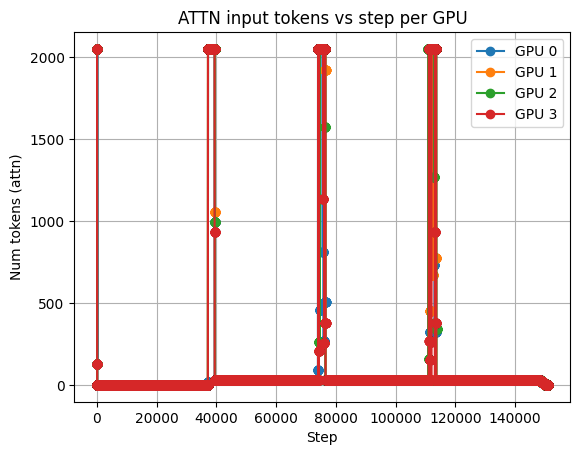

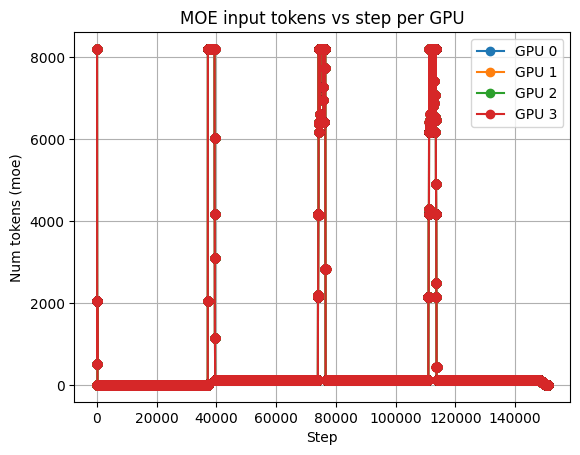

In [14]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt


# --- Parsing helpers ---------------------------------------------------------

def parse_shape_line(line: str):
    """
    Parse one data line of the form:
        <timestamp>;<gpu_id>;<attn_input_shape>;<moe_input_shape>

    Returns:
        (timestamp: float, gpu_id: int, attn_input_shape: str, moe_input_shape: str)
        or None if not a valid data line.
    """
    line = line.strip()
    if not line:
        return None

    # Skip header: "timestamp,gpu_id,attn_input_shape,moe_input_shape"
    if line.startswith("timestamp"):
        return None

    parts = line.split(";")
    if len(parts) != 4:
        return None

    ts_str, gpu_str, attn_shape, moe_shape = parts
    try:
        ts = float(ts_str)
        gpu = int(gpu_str)
    except ValueError:
        return None

    return ts, gpu, attn_shape, moe_shape


_token_re = re.compile(r"torch\.Size\(\[(\d+)")


def shape_to_tokens(shape_str: str) -> int:
    """
    Extract the first dimension from a shape string like:
        'torch.Size([2048, 3072])'  -> 2048
    """
    if not isinstance(shape_str, str):
        return 0
    m = _token_re.search(shape_str)
    if not m:
        return 0
    return int(m.group(1))


# --- Core data functions -----------------------------------------------------

def load_shapes_csv(path: str | Path) -> pd.DataFrame:
    """
    Load the semicolon-separated shape CSV into a DataFrame with columns:
        timestamp, gpu_id, attn_input_shape, moe_input_shape
    """
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Input file not found: {path}")

    rows = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            parsed = parse_shape_line(line)
            if parsed is not None:
                rows.append(parsed)

    if not rows:
        raise ValueError("No data rows parsed. Check input format.")

    df = pd.DataFrame(
        rows,
        columns=["timestamp", "gpu_id", "attn_input_shape", "moe_input_shape"],
    )
    df["timestamp"] = df["timestamp"].astype(float)
    df["gpu_id"] = df["gpu_id"].astype(int)

    # Sort within each GPU by timestamp
    df = df.sort_values(["gpu_id", "timestamp"]).copy()

    # Add per-GPU step index
    df["step"] = df.groupby("gpu_id").cumcount()

    # Extract num tokens (first dim of shape)
    df["attn_tokens"] = df["attn_input_shape"].apply(shape_to_tokens)
    df["moe_tokens"]  = df["moe_input_shape"].apply(shape_to_tokens)

    return df


def plot_tokens_per_gpu(df: pd.DataFrame, which: str = "attn"):
    """
    Plot num tokens vs step for each GPU.

    which: "attn" or "moe"
    """
    if which not in {"attn", "moe"}:
        raise ValueError("which must be 'attn' or 'moe'")

    col = "attn_tokens" if which == "attn" else "moe_tokens"
    ylabel = f"Num tokens ({which})"
    title  = f"{which.upper()} input tokens vs step per GPU"

    gpu_ids = sorted(df["gpu_id"].unique())

    plt.figure()
    for gpu in gpu_ids:
        sub = df[df["gpu_id"] == gpu]
        plt.plot(sub["step"], sub[col], marker="o", label=f"GPU {gpu}")
    plt.xlabel("Step")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_attn_and_moe(df: pd.DataFrame):
    """
    Convenience function: plot both attn and moe tokens vs step.
    """
    plot_tokens_per_gpu(df, which="attn")
    plot_tokens_per_gpu(df, which="moe")


if __name__ == "__main__":
    # path to your shapes CSV
    SHAPE_DIR = "./log/shape"
    csv_path = f"{SHAPE_DIR}/gpt-oss-120b_tp1_dp4_ep1_off0_con128_IN4096_OUT1024.csv"

    df_shapes = load_shapes_csv(csv_path)
    plot_attn_and_moe(df_shapes)

    # Inspect the processed data (optional)
    df_shapes.head()


# Expert Activation Inspection

In [4]:
from pathlib import Path
from collections import defaultdict
import re
import torch
import os
import numpy as np


def compute_layer_counts_by_device_by_step(
    run_dir: str,
    step_min: int,
    step_max: int,
    num_experts: int = 128,
    top1_only: bool = False,
):
    run_dir = Path(run_dir)

    # device -> step -> layer -> counts[expert]
    layer_counts = defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(lambda: torch.zeros(num_experts, dtype=torch.long))
        )
    )

    # Parse: device_{device}_{start}_{end}.pt
    fname_re = re.compile(r"device_(\d+)_(\d{6})_(\d{6})\.pt$")

    # Group files by device so we can break early per-device once start > step_max
    files_by_device = defaultdict(list)

    for fp in run_dir.rglob("device_*.pt"):
        m = fname_re.search(fp.name)
        if not m:
            continue
        dev = int(m.group(1))
        start = int(m.group(2))
        end = int(m.group(3))

        # overlap check (inclusive-safe):
        # skip if file is entirely before or entirely after the desired range
        if end < step_min or start > step_max:
            continue

        files_by_device[dev].append((start, end, fp))

    if not files_by_device:
        raise FileNotFoundError(f"No matching device_*.pt overlapping steps [{step_min}, {step_max}] under: {run_dir}")

    for dev, triples in files_by_device.items():
        # sort by start step; allows early break
        triples.sort(key=lambda t: t[0])

        for start, end, fp in triples:
            if start > step_max:
                break  # no more relevant files for this device

            batch = torch.load(fp, map_location="cpu")
            for e in batch.get("entries", []):
                step = int(e.get("step", -1))
                if step < step_min or step > step_max:
                    continue

                layer = int(e["layer"])
                ids = e["tensor"]

                if top1_only:
                    ids = ids[..., 0]

                ids = ids.reshape(-1).to(torch.int64)
                ids = ids[(ids >= 0) & (ids < num_experts)]
                if ids.numel() == 0:
                    continue

                layer_counts[dev][step][layer] += torch.bincount(ids, minlength=num_experts)[:num_experts]

    return layer_counts


run_dir = "log/expert_activation_pattern/gpt-oss-120b_tp1_dp4_ep1_off0_con256_INShareGPT_OUTShareGPT"

step_min, step_max = 100, 500   # example: skip step 0 automatically by starting at 1
layer_counts_by_step = compute_layer_counts_by_device_by_step(
    run_dir, step_min=step_min, step_max=step_max, num_experts=128, top1_only=False
)

In [5]:

from typing import Dict, DefaultDict, Any


def retain_topk_experts_per_step(
    layer_counts: Any,  # device -> step -> layer -> tensor[num_experts]
    k: int,
    *,
    per_layer: bool = False,
    in_place: bool = False,
) -> Any:
    """
    Keep only top-k experts with highest activation counts.

    - per_layer=False (default): for each (device, step), compute total counts across layers,
      pick top-k experts from that total, and zero-out others in EVERY layer for that step.
    - per_layer=True: for each (device, step, layer), keep that layer's top-k experts.
    - in_place=False (default): returns a new nested dict with cloned tensors.
    """
    if k <= 0:
        raise ValueError("k must be > 0")

    out = layer_counts if in_place else {}

    for dev, steps in layer_counts.items():
        if not in_place:
            out[dev] = {}

        for step, layers in steps.items():
            if not in_place:
                out[dev][step] = {}

            if per_layer:
                # Top-k per (device, step, layer)
                for layer, cnt in layers.items():
                    cnt = cnt if in_place else cnt.clone()
                    kk = min(k, cnt.numel())
                    top_idx = torch.topk(cnt, kk).indices
                    mask = torch.zeros_like(cnt, dtype=torch.bool)
                    mask[top_idx] = True
                    cnt[~mask] = 0

                    if not in_place:
                        out[dev][step][layer] = cnt
            else:
                # Top-k per (device, step) based on total across layers
                total = None
                for cnt in layers.values():
                    total = cnt if total is None else (total + cnt)

                kk = min(k, total.numel())
                top_idx = torch.topk(total, kk).indices
                mask = torch.zeros_like(total, dtype=torch.bool)
                mask[top_idx] = True

                for layer, cnt in layers.items():
                    cnt = cnt if in_place else cnt.clone()
                    cnt[~mask] = 0
                    if not in_place:
                        out[dev][step][layer] = cnt

    return out

layer_counts_top4 = retain_topk_experts_per_step(layer_counts_by_step, k=10)


In [7]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

def plot_3d_layers_side_by_side(
    layer_counts_by_step,
    device: int,
    layers: list[int],
    step_min: int,
    step_max: int,
    num_experts: int = 128,
    ncols: int = 3,
    step_stride: int = 1,
    logz: bool = False,
):
    steps = sorted(s for s in layer_counts_by_step.get(device, {}) if step_min <= s <= step_max)
    steps = steps[::step_stride]
    if not steps:
        raise ValueError("No steps found in the requested range for this device.")

    experts = np.arange(num_experts)

    n = len(layers)
    nrows = math.ceil(n / ncols)

    specs = [[{"type": "scene"} for _ in range(ncols)] for _ in range(nrows)]
    titles = [f"Layer {l}" for l in layers]

    fig = make_subplots(
        rows=nrows,
        cols=ncols,
        specs=specs,
        subplot_titles=titles + [""] * (nrows * ncols - n),
        horizontal_spacing=0.02,
        vertical_spacing=0.06,
    )

    for i, layer in enumerate(layers):
        r = i // ncols + 1
        c = i % ncols + 1

        Z = np.stack(
            [
                layer_counts_by_step[device][s].get(layer, np.zeros(num_experts, dtype=np.int64)).numpy()
                for s in steps
            ],
            axis=0,
        )  # [num_steps, num_experts]

        if logz:
            Z = np.log1p(Z)

        # Show colorbar only on the first subplot to reduce clutter
        showscale = (i == 0)

        fig.add_trace(
            go.Surface(x=experts, y=steps, z=Z, showscale=showscale),
            row=r, col=c
        )

    # Label all scenes (scene, scene2, scene3, ...)
    for k in range(1, nrows * ncols + 1):
        scene_name = "scene" if k == 1 else f"scene{k}"
        if scene_name in fig.layout:
            fig.layout[scene_name].update(
                xaxis_title="Expert ID",
                yaxis_title="Step",
                zaxis_title=("log(1+activations)" if logz else "Num activations"),
            )

    fig.update_layout(
        title=f"Layers {layers} (steps {step_min}..{step_max})",
        height=1000 * nrows,
        width=600 * ncols,
        margin=dict(l=10, r=10, t=60, b=10),
    )

    return fig

import plotly.io as pio

def write_html_with_linked_3d_cameras(fig, out_html: str):
    # Count how many 3D scenes are in the figure
    scene_names = []
    if "scene" in fig.layout:
        scene_names.append("scene")
    i = 2
    while f"scene{i}" in fig.layout:
        scene_names.append(f"scene{i}")
        i += 1

    if len(scene_names) <= 1:
        fig.write_html(out_html, include_plotlyjs="cdn")
        return

    plot_id = "linked-3d"

    # JS: listen for relayout events; when camera changes on any scene, propagate it
    post_script = f"""
    (function() {{
      const gd = document.getElementById('{plot_id}');
      if (!gd) return;

      const scenes = {scene_names};
      let updating = false;

      gd.on('plotly_relayout', function(e) {{
        if (updating) return;

        // Find which scene camera changed (e.g. "scene.camera", "scene2.camera", ...)
        const camKey = Object.keys(e).find(k => k.endsWith('.camera'));
        if (!camKey) return;

        const cam = e[camKey];
        updating = true;

        const update = {{}};
        scenes.forEach(s => {{
          update[s + '.camera'] = cam;
        }});

        Plotly.relayout(gd, update).then(() => {{
          updating = false;
        }}).catch(() => {{
          updating = false;
        }});
      }});
    }})();
    """

    pio.write_html(
        fig,
        out_html,
        include_plotlyjs="cdn",
        full_html=True,
        div_id=plot_id,
        post_script=post_script,
    )


# usage
fig = plot_3d_layers_side_by_side(
    layer_counts_top4,
    device=1,
    layers=list(range(0, 36)),   # pick any set
    step_min=1,
    step_max=500,
    ncols=3,
    step_stride=2,   # increase if it’s heavy
    logz=False,
)

write_html_with_linked_3d_cameras(fig, "layers_grid_synced_cameras.html")
